# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
import numpy as np
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# Hyperparameters of Multiple Agent Collabration and Competition
import torch.cuda

LR_ACTOR = 5e-4                 # Learning rate of actor model
LR_CRITIC = 5e-3                # Learning rate of critic model
TAU = 8e-2                     # Soft Update Parameter
GAMMA = 0.99                    # Discount Factor
BUFFER_SIZE = int(1e5)          # Replay buffer size
BATCH_SIZE = 260                # Batch size for training models
RANDOM_SEED = 0                 # Seeding
WEIGHT_DECAY = 0.               # Weight decay for Critic Model
UPDATE_EVERY = 20               # weight update frequency

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_agents = 2
action_size = 2
state_size = 24

### Neural Networks

In [7]:
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1.0/np.sqrt(fan_in)
    return (-lim,lim)


class Actor(nn.Module):
    """Actor Model -  Takes observation and produces actions based on the Observation"""
    
    def __init__(self, state_size, action_size,fc1_units = 256, fc2_units = 256):
        """Init Method for initialization of actor model
           =============================================
           Params:
           state_size: Number of Observation
           action_size: Array of actions to be controlled
           fc1_units: Number of hidden units in Fc1 Layer
           fc2_units: Number of hidden units in Fc2 layer
        """
        super(Actor,self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
        self.fc1 = nn.Linear(state_size ,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        """Weight Initialization for Actor NN"""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state):
        """Build an actor (policy) network that maps states -> actions."""
        a = F.relu(self.fc1(state))
        a = F.relu(self.fc2(a))
        return F.tanh(self.fc3(a))
    

class Critic(nn.Module):
    """Critic Model -  Takes observation and actions produces policies """
    
    def __init__(self, state_size, action_size,fc1_units = 256, fc2_units = 256):
        """Init Method for initialization of critic model
           =============================================
           Params:
           state_size: Number of Observation
           action_size: Array of actions to be controlled
           fc1_units: Number of hidden units in Fc1 Layer
           fc2_units: Number of hidden units in Fc2 layer
        """
        super(Critic,self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
        self.fc1 = nn.Linear((state_size + action_size) * num_agents,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,1)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()
        
    def reset_parameters(self):
        """Weight Initialization for Critic NN"""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state,action):
        """Build an critic (policy) network that maps states -> actions."""
        ca = torch.cat((state,action.float()),dim = 1)
        a = F.leaky_relu(self.fc1(ca))
        a = self.bn(a)
        a = F.leaky_relu(self.fc2(a))
        return self.fc3(a)

### Ornstein-Uhlenbeck Noise
We need to add noise to the actions or in some way it is kind of exploration given to the learning agent

In [8]:
import random
import copy

class OUNoise():
    """Ornstein-Uhlenbeck process"""

    def __init__(self,size,mu = 0,theta = 0.15, sigma = 0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(RANDOM_SEED)
        self.reset()
        self.size = size
        
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
        
    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx        
        return self.state


## ReplayBuffer
One of the characteristic of Q-learning and it helps to have abundant informtion for learning agent

In [9]:
from collections import deque
from collections import namedtuple
import random
import numpy as np
import torch

class ReplayBuffer():
    def __init__(self,buffer_size,batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.batch_size = batch_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",field_names= ["states","actions","rewards","next_states","dones"])
        
    def add(self,state,action,reward,next_state,done):
        """Add a new experience to memory."""
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k = self.batch_size)
        states = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        rewards = [torch.from_numpy(np.vstack([e.rewards[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        dones = [torch.from_numpy(np.vstack([e.dones[index] for e in experiences if e is not None]).astype(np.uint8)).float().to(device) for index in range(num_agents)]
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### DDPG Agent

In [10]:
import torch.optim as optim

class DDPG_Agent():
    
    def __init__(self,state_size,action_size,index):
        """Initialize a DDPGAgent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            agent_id (int): identifier for this agent
        """
        self.action_size = action_size
        self.state_size = state_size
        self.index = index
        
        self.actor_local = Actor(state_size,action_size).to(device)
        self.actor_target = Actor(state_size,action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr = LR_ACTOR)
        self.critic_local = Critic(state_size,action_size).to(device)
        self.critic_target = Critic(state_size,action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),lr = LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target,self.critic_local)
        
        self.noise = OUNoise(action_size)
        self.timesteps = 0
        
    def hard_update(self,target,source):
        """Hard update model parameters.
        θ_target = θ_local
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_params,source_params in zip(target.parameters(),source.parameters()):
            target_params.data.copy_(source_params.data)
        
       
    def act(self,state,add_noise = True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action,-1,1)
    
    def reset(self):
        """Resets the OU Noise for this agent."""
        self.noise.reset() 
    
    def learn(self,experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(next_state) -> action
            critic_target(next_state, next_action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            next_actions (list): next actions computed from each agent
            actions_pred (list): prediction for actions for current states from each agent
        """
        states,actions,rewards,next_states,dones = experiences
        whole_states = torch.cat(states, dim=1).to(device)
        whole_next_states = torch.cat(next_states, dim=1).to(device)
        whole_actions = torch.cat(actions, dim=1).to(device)
        
        #Next Action Prediction using Target Actor Model
        next_actions = [actions[index].clone() for index in range(num_agents)]
        next_actions[self.index] = self.actor_target(next_states[self.index])
        whole_next_actions = torch.cat(next_actions, dim=1).to(device)
        
        ###CRITIC TRAINING
        Q_target_next = self.critic_target(whole_next_states,whole_next_actions)
        Q_target = rewards[self.index] + GAMMA * Q_target_next *(1-dones[self.index])
        Q_exp = self.critic_local(whole_states,whole_actions)
        critic_loss = F.mse_loss(Q_exp,Q_target)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        #Action Prediction using Local Actor Model 
        actions_pred = [actions[index].clone() for index in range(num_agents)]
        actions_pred[self.index] = self.actor_local(states[self.index])
        whole_actions_pred = torch.cat(actions_pred, dim=1).to(device)
        
        ### ACTOR TRAINING
        self.actor_optimizer.zero_grad()
        actor_loss = -self.critic_local(whole_states, whole_actions_pred).mean()
        actor_loss.backward()
        self.actor_optimizer.step()

        ### Update target networks
        if self.timesteps % 4 == 0:
            self.soft_update(self.critic_local, self.critic_target, TAU)
            self.soft_update(self.actor_local, self.actor_target, TAU)
        
        
    def soft_update(self,local,target,tau):
        """Soft update model parameters.
        θ_target = τ * θ_local + (1 - τ) * θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_params,local_params in zip(target.parameters(),local.parameters()):
            target_params.data.copy_(tau * local_params.data + (1.0 - tau) * target_params.data)

### MADDPG

In [11]:
class MADDPG():
    """Wrapper class managing different agents in the environment."""
    
    def __init__(self, num_agents, state_size, action_size):
        """Initialize a MADDPGAgent wrapper.
        Params
        ======
            num_agents (int): the number of agents in the environment
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.agents = [DDPG_Agent(state_size,action_size,x)  for x in range(num_agents)]
        
        
    def reset(self):
        """Resets OU Noise for each agent."""
        for agent in self.agents:
            agent.reset()
    
    def act(self,state,add_noise = True):
        """Picks an action for each agent given their individual observations 
        and the current policy."""
        action = np.zeros([self.num_agents, self.action_size])
        for index,agent in enumerate(self.agents):
            action[index,:] = agent.act(state[index],add_noise = add_noise)
        return action
    
    def step(self,states,actions,rewards,next_states,dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.memory.add(states,actions,rewards,next_states,dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            for index,agent in enumerate(self.agents):
                agent.learn(experiences)
        
    def save(self):
        """Save Weights of every agent"""
        for index,agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_'+str(index)+ '.pth')
            torch.save(agent.critic_local.state_dict(),'checkpoint_critic_'+str(index)+ '.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_target_'+str(index)+ '.pth')
            torch.save(agent.critic_target.state_dict(),'checkpoint_critic_target_'+str(index)+ '.pth')

In [12]:
def trainer(maddpg,env,n_episodes=4000,print_every = 100):
    """main function to run training model"""
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    for i_episode in range(1,n_episodes+1):                    
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        maddpg.reset()
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = maddpg.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished                                
            maddpg.step(states,actions,rewards,next_states,dones)
            scores += rewards 
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        max_scores = np.max(scores)       
        scores_deque.append(max_scores)
        scores_list.append(max_scores)
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, average_score), end="")
        if(average_score >=  0.5):
            maddpg.save()
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, average_score))
    
    return scores_list

In [13]:
multi_agent = MADDPG( num_agents, state_size, action_size)
scores = trainer(multi_agent,env)

Episode 100	Average Score: 0.0101
Episode 200	Average Score: 0.0317
Episode 300	Average Score: 0.0463
Episode 400	Average Score: 0.0392
Episode 500	Average Score: 0.0531
Episode 600	Average Score: 0.0632
Episode 700	Average Score: 0.0687
Episode 800	Average Score: 0.0769
Episode 900	Average Score: 0.0699
Episode 1000	Average Score: 0.0927
Episode 1100	Average Score: 0.1512
Episode 1200	Average Score: 0.2208
Episode 1300	Average Score: 0.4159
Episode 1400	Average Score: 0.4619
Episode 1434	Average Score: 0.5001

### Plot of episodes vs score

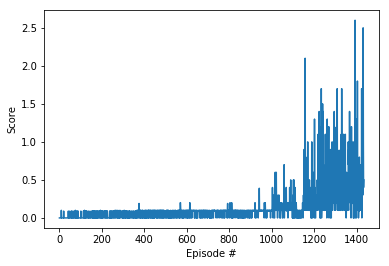

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [15]:
env.close()

### Further Training
The stability of the algorithm is still questionable - using something like PPO, [A3C](https://arxiv.org/pdf/1602.01783.pdf) instead may stabilize training.Additionally, since so many training epochs feature zero reward, implementing [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) may speed up training by prioritizing epochs with nonzero reward.